In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import cv2


565 235


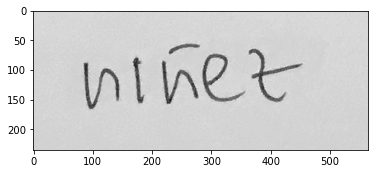

In [2]:
from preproc import FastBinarize

test = "../data-sources/spanish-words/w07_rgb_28.png"
image = FastBinarize.imread(test, grayscale=False)

gray = FastBinarize.to_grayscale(image)
h, w = gray.shape

print(w, h)
plt.imshow(gray, cmap="gray")
plt.show()

1242 1280


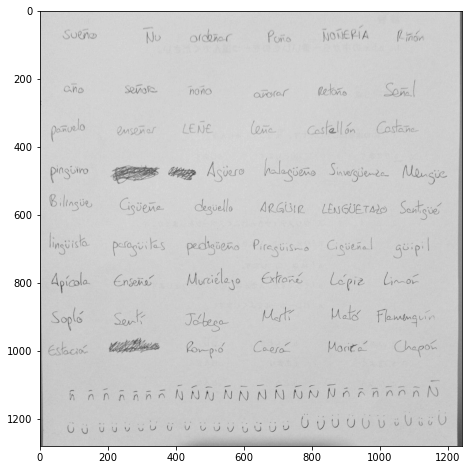

In [25]:
# test = "../data-sources/spanish-words-originals/test3_mini.jpg"
# test = "../data-sources/spanish-words-originals/test3.jpg"
# test = "../data-sources/spanish-words-originals/test2.JPG"
test = "../data-sources/spanish-words-originals/test1.JPG"
test = "../data-sources/spanish-words-originals/txto_alex.jpg"
image = cv2.cvtColor(cv2.imread(test), cv2.COLOR_BGR2RGB)

gray = RobustBinarize.to_grayscale(image)
h, w = gray.shape

print(w, h)
plt.figure(figsize=(8,8))
plt.imshow(gray, cmap="gray")
plt.show()

---

# Original Script

In [3]:
import numpy as np
import cv2

#get histogram
def get_hist(img):
    bins = np.arange(0, 300, 10)
    bins[26] = 255
    hp = np.histogram(img, bins)
    return hp

#histogram reducing value
def get_hr(hp, sqrt_hw):
    for i in range(len(hp[0])):
        if hp[0][i] > sqrt_hw:
            return i * 10
        
#get contrast enhenced image
def get_CEI(img, hr, c):
    CEI = (img - (hr + 50 * c)) * 2
    CEI[np.where(CEI > 255)] = 255
    CEI[np.where(CEI < 0)] = 0
    return CEI
                
#draw image
def draw(img):
    tmp = img.astype(np.uint8)
    cv2.imshow('image',tmp)
    cv2.waitKey(3000)
    cv2.destroyAllWindows()


#scale to 0 - 255
def scale(img):
   s = np.max(img) - np.min(img) 
   res = img / s
   res -= np.min(res)
   res *= 255
   return res

#get threshold for the avg edge image
def get_th(img, bins):
    hist = np.histogram(img,bins)
    peak_1_index = np.argmax(hist[0])
    peak_2_index = 0
    if peak_1_index == 0:
        peak_2_index += 1
    for i in range(len(hist[0])):
        if hist[0][i] > hist[0][peak_2_index] and i != peak_1_index:
            peak_2_index = i
    peak_1 = hist[1][peak_1_index]
    peak_2 = hist[1][peak_2_index]
    return ((peak_1 + peak_2) / 2), hist

def get_th2(img, bins):
    num = img.shape[0] * img.shape[1]
    hist = np.histogram(img, bins)
    cdf = 0
    for i in range(len(hist[0])):
        cdf += hist[0][i]
        if cdf / num > 0.85:
            return hist[1][i]

#threshold the image
def img_threshold(th, img, flag):
    h = img.shape[0]
    w = img.shape[1]
    new_img = np.zeros((h,w))
    if flag == "H2H":
        new_img[np.where(img >= th)] = 255
    elif flag == "H2L":
        new_img[np.where(img < th)] = 255
    return new_img

# merge cei and edge map
def merge(edge, cei):
    h = edge.shape[0]
    w = edge.shape[1]
    new_img = 255 * np.ones((h,w))

    new_img[np.where(edge == 255)] = 0
    new_img[np.where(cei == 255)] = 0
    return new_img

def find_end(tli, x, y):
    i = x
    while(i < tli.shape[0] and tli[i][y] == 0):
        i += 1
    return i - 1

def find_mpv(cei, head, end, y):
    h = []
    e = []
    for k in range(5):
        if head - k >= 0:
            h.append(cei[head-k][y])
        if end + k < cei.shape[0]:
            e.append(cei[end + k][y])
    return np.max(h), np.max(e)
    
    
# set interpolated image
def set_intp_img(img, x, y, tli, cei):
    head = x
    end = find_end(tli, x, y)
    n = end - head + 1
    if n > 30:
        return end
    mpv_h, mpv_e = find_mpv(cei, head, end, y)
    for m in range(n):
        img[head+m][y] = mpv_h + (m + 1) * ((mpv_e - mpv_h) / n) 
    return end

In [12]:
gray = gray.astype(np.float32)

height = gray.shape[0]
width = gray.shape[1]


#%% STEP: contrast enhancement
print("Enhancing Contrast")
hp = get_hist(image)
sqrt_hw = np.sqrt(height * width)
hr = get_hr(hp, sqrt_hw)
cei = get_CEI(gray, hr, 0.3)
# cv2.imwrite(FILE_NAME + "_Cei" + FORMAT, cei)

#%% STEP: Edge detection
print("Edge Detection")
# build four filters
m1 = np.array([-1,0,1,-2,0,2,-1,0,1]).reshape((3,3))
m2 = np.array([-2,-1,0,-1,0,1,0,1,2]).reshape((3,3))
m3 = np.array([-1,-2,-1,0,0,0,1,2,1]).reshape((3,3))
m4 = np.array([0,1,2,-1,0,1,-2,-1,0]).reshape((3,3))

eg1 = np.abs(cv2.filter2D(gray, -1, m1))
eg2 = np.abs(cv2.filter2D(gray, -1, m2))
eg3 = np.abs(cv2.filter2D(gray, -1, m3))
eg4 = np.abs(cv2.filter2D(gray, -1, m4))
eg_avg = scale((eg1 + eg2 + eg3 + eg4) / 4)

bins_1 = np.arange(0, 265, 5) 
#threshold = get_th2(eg_avg, bins_1)
eg_bin = img_threshold(30, eg_avg,"H2H") #threshold is hard coded to 30 (based 
                                         #on the paper). Uncomment above to replace
# cv2.imwrite(FILE_NAME + "_EdgeBin" + FORMAT, eg_bin)


#%% STEP: Text location
print("Locating the Text")
bins_2 = np.arange(0, 301, 40)
#threshold_c = 255 - get_th2(cei, bins_2)
cei_bin = img_threshold(60, cei, "H2L")#threshold is hard coded to 60 (based 
                                       #on the paper). Uncomment above to replace
# cv2.imwrite(FILE_NAME + "_CeiBin" + FORMAT, cei_bin)
tli = merge(eg_bin, cei_bin)
# cv2.imwrite(FILE_NAME + "_TLI" + FORMAT, tli)
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(tli,kernel,iterations = 1)
# cv2.imwrite(FILE_NAME + "_TLI_erosion" + FORMAT, erosion)

Enhancing Contrast
Edge Detection
Locating the Text


In [13]:
%%time
print("Estimate Light Distribution")
int_img = np.array(cei)
# ratio = int(width / 20)
for y in range(width):
#     if y % ratio == 0 :
#         print(int(y / width * 100), "%")
    for x in range(height):
        if erosion[x][y] == 0:
            x = set_intp_img(int_img, x, y, erosion, cei)
mean_filter = 1 / 121 * np.ones((11,11), np.uint8)
ldi = cv2.filter2D(scale(int_img), -1, mean_filter)
# cv2.imwrite(FILE_NAME + "_LDI" + FORMAT, ldi)

Estimate Light Distribution
Wall time: 16.3 s


In [14]:
result = np.divide(cei, ldi) * 260
result[np.where(erosion != 0)] *= 1.5
result[result < 0] = 0
result[result > 255] = 255

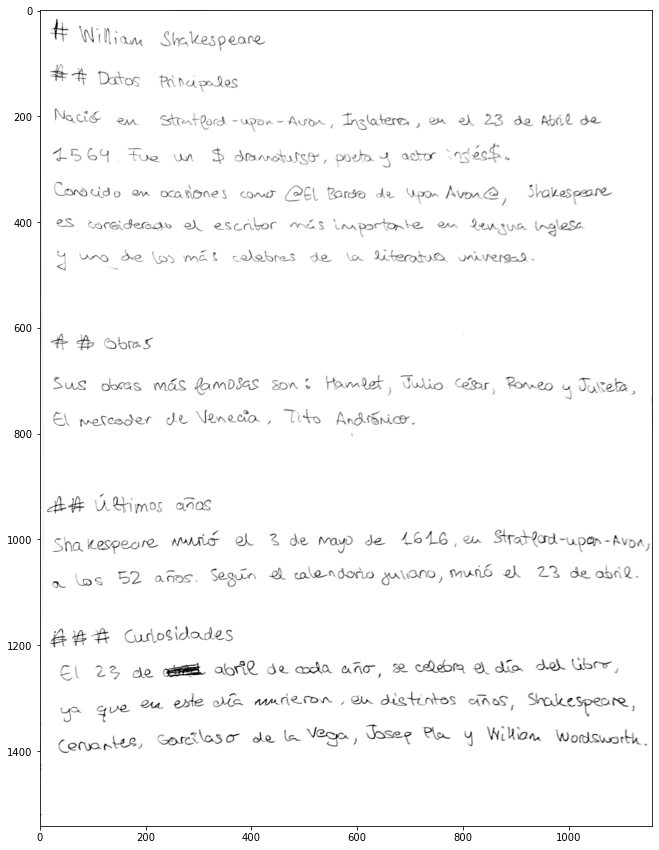

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(result, cmap="gray")

In [16]:
from preproc import RobustBinarize, FastBinarize

In [26]:
%%time
result1 = RobustBinarize.illumination_compensation(image)

Wall time: 253 ms


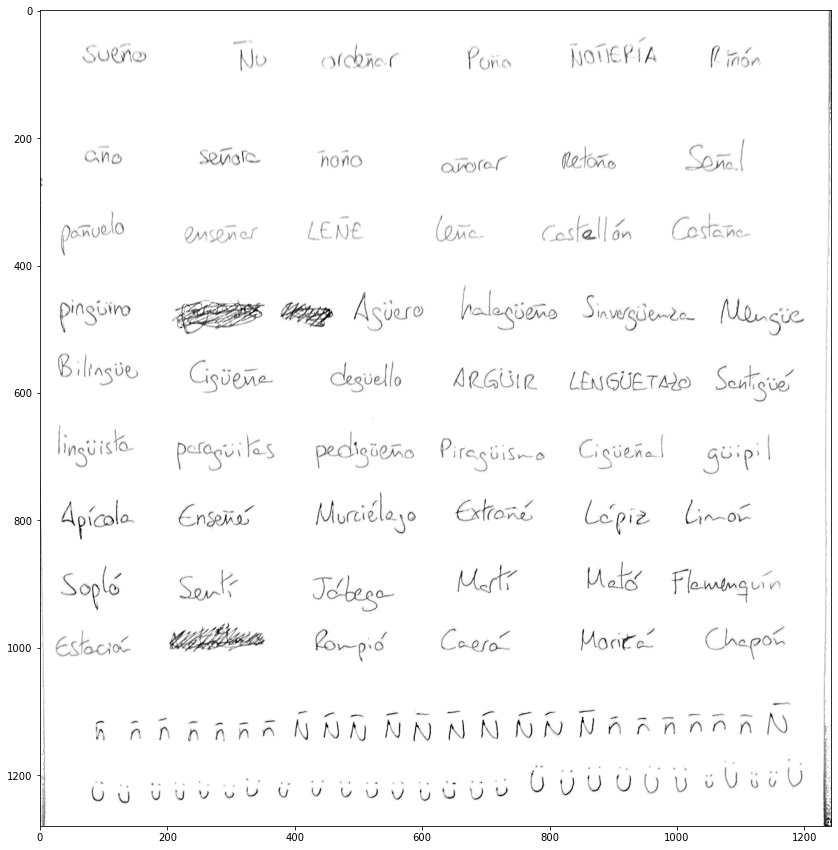

In [27]:
plt.figure(figsize=(15,15))
plt.imshow(result1, cmap="gray")